## Handwritten Digit Recognition using LeNet-5 Architecture

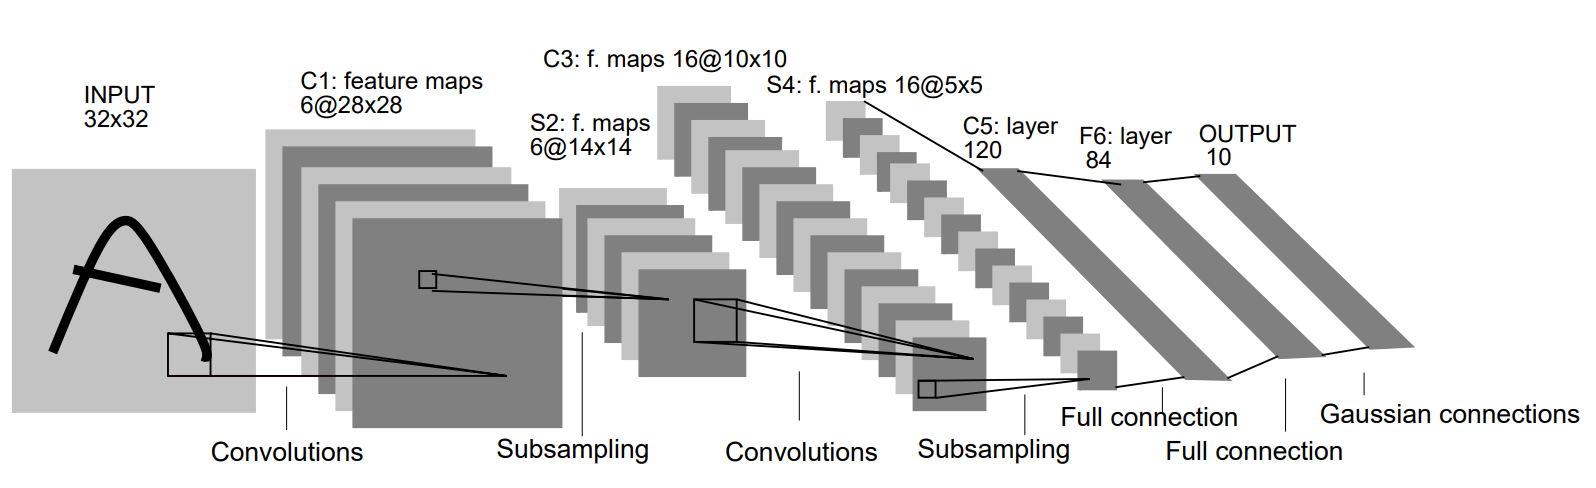
Implementing the LeNet-5 architecture proposed by Yann LeCun in 1998 for Handwritten digit recognition

## The architecture
* Input is 32 x 32 grayscale image. This goes into the convolution layer (First convolution layer) — The filter size is 5 x 5 and the striding (hovering) is set as one.
* Once the convolution is successful, the size of the input sample is reduced to 6 @ 28 x 28
* Upon downsampling it using average pooling and using filter size as 2 x 2 and stride as 2, the size reduces by half by becoming 6 @ 14 x 14

* Convolution happens again and 6 @ 14 x 14 gets restructured as 6 @ 10 x 10 with 16 available feature maps
* This layer is going to get sub sampled again with filter size 2 x 2 and the stride as 2
* The 10 x 10 gets reduced to 16 @ 5 x 5

* The fifth layer is a fully connected layer with 120 feature maps, each of size 1 x 1
* Each of the 120 units in C5 is connected to all the 400 nodes (5x5x16) in the fourth layer S4.
* The sixth layer is a fully connected layer with 84 units
* Fully connected softmax output layer with 10 possible values range from 0 to 9 in step 7

## The streamlined flow
### Step 1 - MNIST Dataset preparation & analysis

**Dataset** => Analyze -> Transform -> Split into Train/Valuation/Testing set -> Dataloader

### Step 2 - LeNet-5 architecture and everything else related to training and evaluation of the model

**Model** => Build -> Setup Loss, Optimizer & Metrics -> Train -> Evaluate -> Analyze metrics

# Part I: MNIST dataset prep

In [265]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

BATCH_SIZE = 32
torch.manual_seed(42)
%matplotlib inline

In [266]:
train_val_dataset = datasets.MNIST(root="./datasets/", train=True, download=True)
test_dataset = datasets.MNIST(root="./datasets/", train=False, download=True)

In [267]:
train_val_dataset, test_dataset

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ./datasets/
     Split: Train,
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ./datasets/
     Split: Test)

In [268]:
class_names = train_val_dataset.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

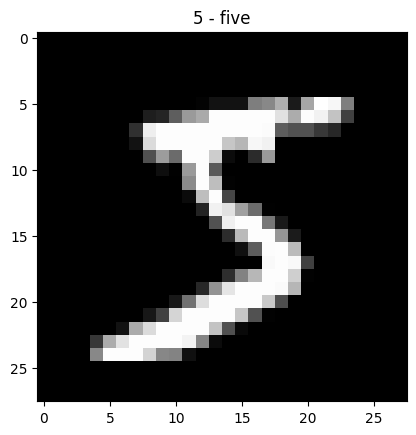

In [269]:
# seeing an example image
img, label = train_val_dataset[0]
img, label

plt.imshow(img, cmap='gray')
plt.title(f"{class_names[label]}");

In [270]:
# visualizing pixel density values

def img_pixel_superimpose(img, ax):
    w, h = img.shape
    color_map = plt.cm.get_cmap('gray_r')
    ax.imshow(img, cmap='gray')
    for x in range(w):
        for y in range(h):
            color = color_map(img[x][y])
            ax.annotate(str(img[x][y]), xy=(y,x), horizontalalignment='center', verticalalignment='center',
                        color=color)
            plt.axis(False)

<ipython-input-270-cd9ed97fa7e5>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('gray_r')


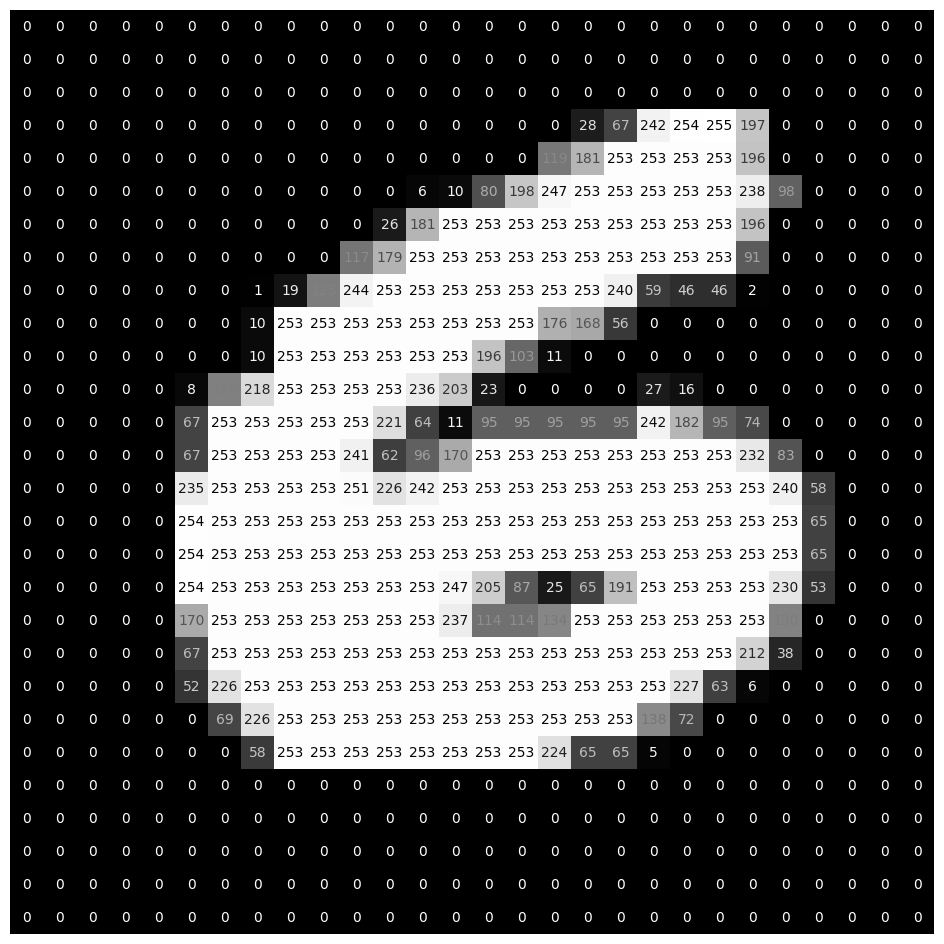

In [271]:
torch.manual_seed(42)

fig = plt.figure(figsize = (12,12))
ax0 = fig.add_subplot(1, 1, 1)

rand_ind = torch.randint(0, len(train_val_dataset), size=[1]).item()

img0 = train_val_dataset.data[rand_ind]
img0 = img0.numpy()
img_pixel_superimpose(img0, ax0)

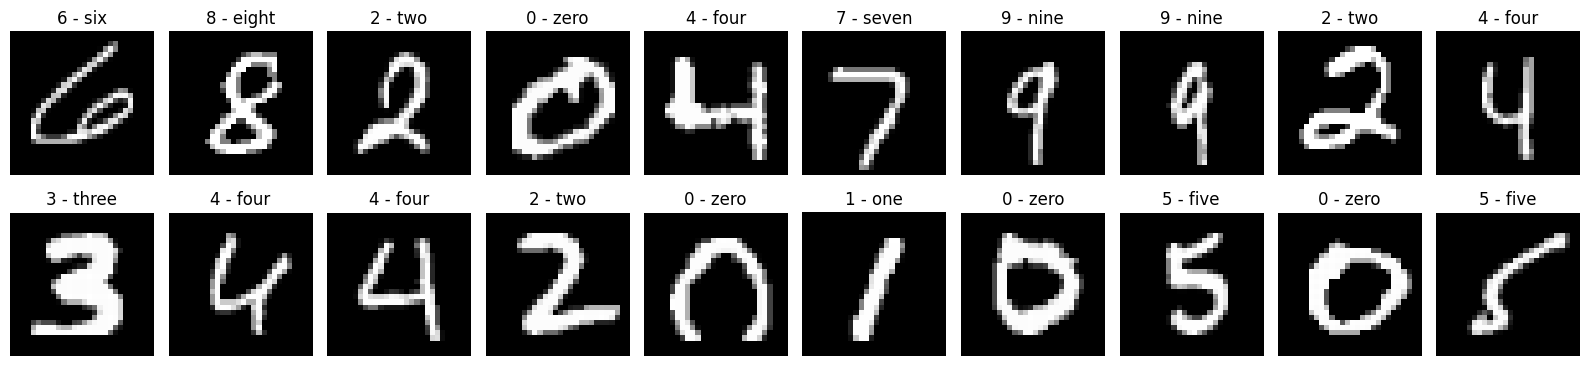

In [272]:
# Viewing more samples
fig = plt.figure(figsize=(16, 4))
rows, cols = 2, 10

for i in range(1, (rows*cols) + 1):
    rand_ind = torch.randint(0, len(train_val_dataset), size=[1]).item()
    img, label = train_val_dataset[rand_ind]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img, cmap='gray')
    plt.title(f"{class_names[label]}")
    plt.axis(False)
    plt.tight_layout()

In [273]:
train_val_dataset = datasets.MNIST(root="./datasets/", train=True, download=False, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root="./datasets", train=False, download=False, transform=transforms.ToTensor())

imgs = torch.stack([img for img, _ in train_val_dataset], dim=0)

mean = imgs.view(1, -1).mean(dim=1)
std = imgs.view(1, -1).std(dim=1)
mean, std

(tensor([0.1307]), tensor([0.3081]))

In [274]:
color_jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
random_grayscale = transforms.RandomGrayscale(p=0.5)

random_invert = transforms.RandomInvert(p=0.5)

train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=(-15, 15)),
    random_invert,
    random_grayscale,
    transforms.ToTensor(),
])

val_test_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_val_dataset = datasets.MNIST(root="./datasets/", train=True, download=False, transform=train_transform)
test_dataset = datasets.MNIST(root="./datasets/", train=False, download=False, transform=val_test_transform)

print("Train/Val Dataset:", train_val_dataset)
print("Test Dataset:", test_dataset)

Train/Val Dataset: Dataset MNIST
    Number of datapoints: 60000
    Root location: ./datasets/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               RandomInvert(p=0.5)
               RandomGrayscale(p=0.5)
               ToTensor()
           )
Test Dataset: Dataset MNIST
    Number of datapoints: 10000
    Root location: ./datasets/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [275]:
train_size = int(0.9 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset=train_val_dataset, lengths=[train_size, val_size])
len(train_dataset), len(val_dataset), len(test_dataset)

(54000, 6000, 10000)

In [276]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

len(train_dataloader), len(val_dataloader), len(test_dataloader)

(1688, 188, 313)

## Part II: LeNet-5 architecture

In [277]:
!pip install torchinfo torchmetrics

In [278]:
from torch import nn
from torchinfo import summary
from torchmetrics import Accuracy
from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter
from PIL import Image, ImageOps

from datetime import datetime
import os

In [279]:
import torch.nn.functional as F

class LeNet5(nn.Module):
    def __init__(self, dropout_rate=0.5, weight_decay=1e-5):
        super().__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(6),

            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(16),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*5*5, out_features=120),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.BatchNorm1d(120),

            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.BatchNorm1d(84),

            nn.Linear(in_features=84, out_features=10),
        )

    def forward(self, x):
        return self.classifier(self.feature(x))

model_lenet5 = LeNet5()

print(model_lenet5)

LeNet5(
  (feature): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
    (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=400, out_features=120, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Linear(in_features=120, out_features=84, bias=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=84,

In the original paper architecture input is shown as 32x32. But we have seen in our dataset analysis that the images are 28x28. Basically, here input images (28x28) have been padded with 2 all sides to make it a 32x32 dimension.

In [280]:
summary(model=model_lenet5, input_size=(1, 1, 28, 28), col_width=20,
                  col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'], verbose=0)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
LeNet5 (LeNet5)                          [1, 1, 28, 28]       [1, 10]              --                   True
├─Sequential (feature)                   [1, 1, 28, 28]       [1, 16, 5, 5]        --                   True
│    └─Conv2d (0)                        [1, 1, 28, 28]       [1, 6, 28, 28]       156                  True
│    └─ReLU (1)                          [1, 6, 28, 28]       [1, 6, 28, 28]       --                   --
│    └─AvgPool2d (2)                     [1, 6, 28, 28]       [1, 6, 14, 14]       --                   --
│    └─BatchNorm2d (3)                   [1, 6, 14, 14]       [1, 6, 14, 14]       12                   True
│    └─Conv2d (4)                        [1, 6, 14, 14]       [1, 16, 10, 10]      2,416                True
│    └─ReLU (5)                          [1, 16, 10, 10]      [1, 16, 10, 10]      --                   --
│    └─AvgPool2d (6)

In [281]:
# setting up the loss function, optimizer and eval metrics

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_lenet5.parameters(), lr=0.001)
accuracy = Accuracy(task='multiclass', num_classes=10)

In [282]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
accuracy = accuracy.to(device)
model_lenet5 = model_lenet5.to(device)

EPOCHS = 12

for epoch in tqdm(range(EPOCHS)):
    # Training loop
    train_loss, train_acc = 0.0, 0.0
    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)

        model_lenet5.train()

        y_pred = model_lenet5(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        acc = accuracy(y_pred, y)
        train_acc += acc

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    # Validation loop
    val_loss, val_acc = 0.0, 0.0
    model_lenet5.eval()
    with torch.inference_mode():
        for X, y in val_dataloader:
            X, y = X.to(device), y.to(device)

            y_pred = model_lenet5(X)

            loss = loss_fn(y_pred, y)
            val_loss += loss.item()

            acc = accuracy(y_pred, y)
            val_acc += acc

        val_loss /= len(val_dataloader)
        val_acc /= len(val_dataloader)

    print(f"Epoch: {epoch}| Train loss: {train_loss: .5f}| Train acc: {train_acc: .5f}| Val loss: {val_loss: .5f}| Val acc: {val_acc: .5f}")

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 0| Train loss:  0.65190| Train acc:  0.80010| Val loss:  0.13229| Val acc:  0.95961
Epoch: 1| Train loss:  0.29187| Train acc:  0.91658| Val loss:  0.12132| Val acc:  0.96376
Epoch: 2| Train loss:  0.24584| Train acc:  0.93009| Val loss:  0.11136| Val acc:  0.96958
Epoch: 3| Train loss:  0.20997| Train acc:  0.93968| Val loss:  0.07996| Val acc:  0.97523
Epoch: 4| Train loss:  0.20094| Train acc:  0.94350| Val loss:  0.06727| Val acc:  0.97822
Epoch: 5| Train loss:  0.16949| Train acc:  0.95292| Val loss:  0.08170| Val acc:  0.98205
Epoch: 6| Train loss:  0.16553| Train acc:  0.95350| Val loss:  0.05789| Val acc:  0.98138
Epoch: 7| Train loss:  0.15953| Train acc:  0.95488| Val loss:  0.07840| Val acc:  0.97989
Epoch: 8| Train loss:  0.14964| Train acc:  0.95692| Val loss:  0.05014| Val acc:  0.98471
Epoch: 9| Train loss:  0.13408| Train acc:  0.96166| Val loss:  0.08198| Val acc:  0.98471
Epoch: 10| Train loss:  0.12926| Train acc:  0.96394| Val loss:  0.05632| Val acc:  0.9825

As can be seen with just this simple CNN architecture we are able to achieve training accuracy and validation accuracy of ~99%.



In [283]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "lenet5_mnist.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving the model: {MODEL_SAVE_PATH}")
torch.save(obj=model_lenet5.state_dict(), f=MODEL_SAVE_PATH)

model_lenet5_mnist_loaded = LeNet5()
model_lenet5_mnist_loaded.load_state_dict(torch.load(MODEL_SAVE_PATH))

Saving the model: models/lenet5_mnist.pth


<All keys matched successfully>

### Evaluating the model

In [284]:
test_loss, test_acc = 0, 0

model_lenet5_mnist_loaded.to(device)

model_lenet5_mnist_loaded.eval()
with torch.inference_mode():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = model_lenet5_mnist_loaded(X)

        test_loss += loss_fn(y_pred, y)
        test_acc += accuracy(y_pred, y)

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

print(f"Test loss: {test_loss: .5f} | Test acc: {test_acc: .5f}")

Test loss:  0.02922 | Test acc:  0.99032


So the model is able to generalize on unseen digits very well with an accuracy of ~99%. Let’s get out of the numbers game and see the actual predictions:



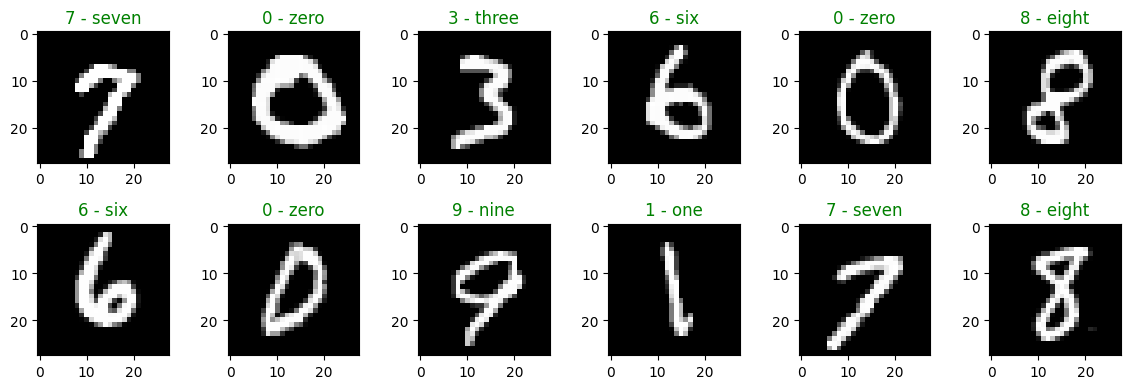

In [285]:
# See random images with their labels
fig = plt.figure(figsize=(12, 4))

rows, cols = 2, 6
for i in range(1, (rows * cols) + 1):
    random_idx = torch.randint(0, len(test_dataset), size=[1]).item()
    img, label_gt = test_dataset[random_idx]
    img_temp = img.unsqueeze(dim=0).to(device)
    label_pred = torch.argmax(model_lenet5_mnist_loaded(img_temp))

    fig.add_subplot(rows, cols, i)
    img = img.permute(1, 2, 0)
    plt.imshow(img, cmap='gray')

    if label_pred == label_gt:
        plt.title(class_names[label_pred], color='g')
    else:
        plt.title(f'{class_names[label_pred]} ({class_names[label_gt]})', color='r')

    plt.tight_layout()

plt.show()

Let's create a function to predict custom images

In [304]:
from PIL import ImageOps
from tabulate import tabulate

def predict_custom(model, image_path, class_names, invert=True, debug=False):
    original_image = Image.open(image_path).convert('L')

    if invert:
        inverted_image = ImageOps.invert(original_image)
    else:
        inverted_image = original_image.copy()

    transform = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
    ])

    original_input = transform(original_image).unsqueeze(0).to(device)
    inverted_input = transform(inverted_image).unsqueeze(0).to(device)

    with torch.no_grad():
        model.eval()
        original_output = model(original_input)
        inverted_output = model(inverted_input)

        original_probabilities = torch.nn.functional.softmax(original_output[0], dim=0).cpu().numpy()
        inverted_probabilities = torch.nn.functional.softmax(inverted_output[0], dim=0).cpu().numpy()

        original_prediction = torch.argmax(original_output).item()
        inverted_prediction = torch.argmax(inverted_output).item()

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    axes[0].imshow(original_image, cmap='gray')
    axes[0].set_title(f'Original - Prediction: {class_names[original_prediction]}')
    axes[0].axis('off')

    axes[1].imshow(inverted_image, cmap='gray')
    axes[1].set_title(f'Inverted - Prediction: {class_names[inverted_prediction]}')
    axes[1].axis('off')

    plt.show()

    if debug:
        headers = ["Class", "Original Probabilities", "Inverted Probabilities"]
        data = [[class_names[i], original_probabilities[i], inverted_probabilities[i]] for i in range(len(class_names))]

        print(tabulate(data, headers=headers, tablefmt="grid"))

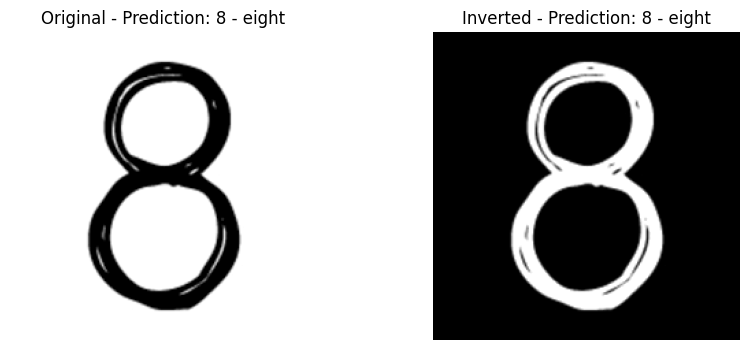

+-----------+--------------------------+--------------------------+
| Class     |   Original Probabilities |   Inverted Probabilities |
+===========+==========================+==========================+
| 0 - zero  |              0.000217523 |              6.99517e-05 |
+-----------+--------------------------+--------------------------+
| 1 - one   |              7.13342e-05 |              2.42297e-05 |
+-----------+--------------------------+--------------------------+
| 2 - two   |              0.00579201  |              0.00408082  |
+-----------+--------------------------+--------------------------+
| 3 - three |              0.00720201  |              0.0068522   |
+-----------+--------------------------+--------------------------+
| 4 - four  |              6.80055e-06 |              4.40896e-06 |
+-----------+--------------------------+--------------------------+
| 5 - five  |              0.000132444 |              4.10214e-05 |
+-----------+--------------------------+--------

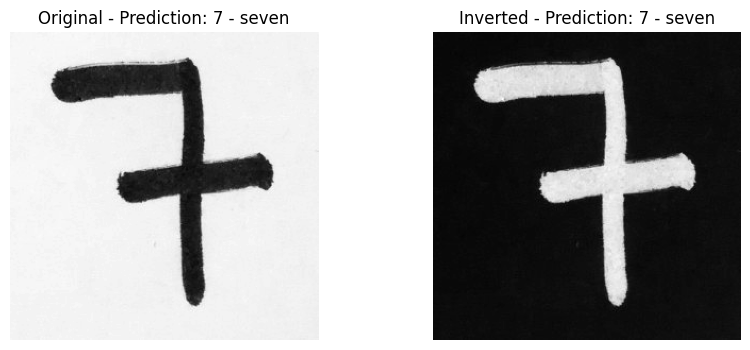

+-----------+--------------------------+--------------------------+
| Class     |   Original Probabilities |   Inverted Probabilities |
+===========+==========================+==========================+
| 0 - zero  |              7.22534e-05 |              6.15317e-05 |
+-----------+--------------------------+--------------------------+
| 1 - one   |              0.0029368   |              0.0134557   |
+-----------+--------------------------+--------------------------+
| 2 - two   |              0.0582038   |              0.0225612   |
+-----------+--------------------------+--------------------------+
| 3 - three |              0.184387    |              0.224542    |
+-----------+--------------------------+--------------------------+
| 4 - four  |              0.00474227  |              0.0422308   |
+-----------+--------------------------+--------------------------+
| 5 - five  |              0.000306103 |              0.00105108  |
+-----------+--------------------------+--------

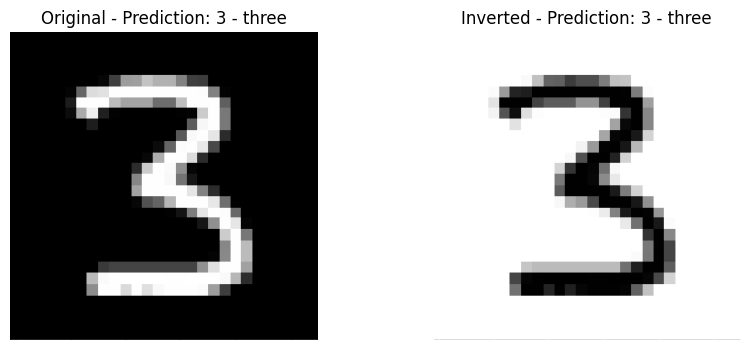

+-----------+--------------------------+--------------------------+
| Class     |   Original Probabilities |   Inverted Probabilities |
+===========+==========================+==========================+
| 0 - zero  |              9.21335e-10 |              8.87272e-09 |
+-----------+--------------------------+--------------------------+
| 1 - one   |              1.50388e-07 |              5.96141e-07 |
+-----------+--------------------------+--------------------------+
| 2 - two   |              6.9125e-07  |              2.69865e-06 |
+-----------+--------------------------+--------------------------+
| 3 - three |              0.999995    |              0.99998     |
+-----------+--------------------------+--------------------------+
| 4 - four  |              4.16072e-09 |              1.7496e-08  |
+-----------+--------------------------+--------------------------+
| 5 - five  |              2.87786e-06 |              1.15594e-05 |
+-----------+--------------------------+--------

In [305]:
test_arr = ["eight.png", "seven.jpg", "three.png"]
for i in test_arr:
  predict_custom(model_lenet5_mnist_loaded, i, class_names, invert=True, debug=True)


The model works as expected

Let's try out some other images just for fun

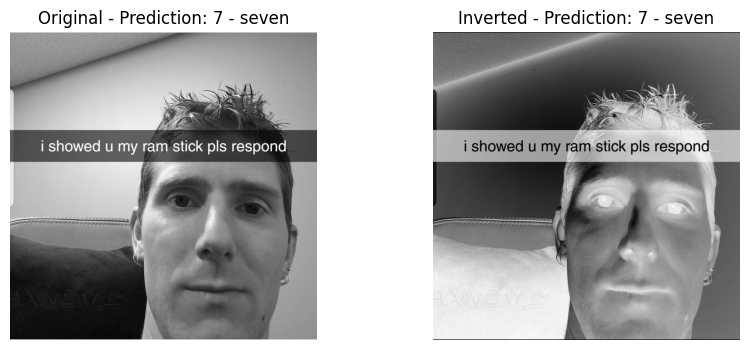

In [309]:
predict_custom(model_lenet5_mnist_loaded, "linus.jpg", class_names)

It doesn't work with this image but can't really blame the model for that lol